# Dataset Modelling

# Importing libraries and dataset

In [5]:
!pip install factor_analyzer
!pip install ruptures
!pip install numpy scikit-learn pyod
!pip install mrmr_selection


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [169]:
#Importing Data and Exploratory Analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from scipy.stats import chi2

#Pre-Processing
from factor_analyzer.factor_analyzer import calculate_kmo
import ruptures as rpt
from sklearn.decomposition import PCA
from pyod.models.pca import PCA as RobustPCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import f
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from mrmr import mrmr_regression
from sklearn.preprocessing import MinMaxScaler

#Models
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
#import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import BayesianRidge

In [2]:
df = pd.read_csv(r'C:\Users\User\Wastewater-Treatment-Sector-Dataset\Data-Melbourne_F.csv')
df.head()

avg_outflow  avg_inflow  total_grid    Am    BOD     COD      TN     T  \
0        2.941       2.589      175856  27.0  365.0   730.0  60.378  19.3   
1        2.936       2.961      181624  25.0  370.0   740.0  60.026  17.1   
2        2.928       3.225      202016  42.0  418.0   836.0  64.522  16.8   
3        2.928       3.354      207547  36.0  430.0   850.0  63.000  14.6   
4        2.917       3.794      202824  46.0  508.0  1016.0  65.590  13.4   

     TM    Tm  SLP   H    PP    VV     V    VM    VG  year  month  day  
0  25.1  12.6  0.0  56  1.52  10.0  26.9  53.5  79.5  2014      1    1  
1  23.6  12.3  0.0  63  0.00  10.0  14.4  27.8   0.0  2014      1    2  
2  27.2   8.8  0.0  47  0.25  10.0  31.9  61.1  77.8  2014      1    5  
3  19.9  11.1  0.0  49  0.00  10.0  27.0  38.9  53.5  2014      1    6  
4  19.1   8.0  0.0  65  0.00  10.0  20.6  35.2  53.5  2014      1    7

In [3]:
df = df.drop('VG', axis=1) # I'm dropping this feature because it is not described in the article 
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)
df.drop(columns=['year', 'month', 'day'], inplace=True)
df.head()

avg_outflow  avg_inflow  total_grid    Am    BOD     COD      TN  \
date                                                                           
2014-01-01        2.941       2.589      175856  27.0  365.0   730.0  60.378   
2014-01-02        2.936       2.961      181624  25.0  370.0   740.0  60.026   
2014-01-05        2.928       3.225      202016  42.0  418.0   836.0  64.522   
2014-01-06        2.928       3.354      207547  36.0  430.0   850.0  63.000   
2014-01-07        2.917       3.794      202824  46.0  508.0  1016.0  65.590   

               T    TM    Tm  SLP   H    PP    VV     V    VM  
date                                                           
2014-01-01  19.3  25.1  12.6  0.0  56  1.52  10.0  26.9  53.5  
2014-01-02  17.1  23.6  12.3  0.0  63  0.00  10.0  14.4  27.8  
2014-01-05  16.8  27.2   8.8  0.0  47  0.25  10.0  31.9  61.1  
2014-01-06  14.6  19.9  11.1  0.0  49  0.00  10.0  27.0  38.9  
2014-01-07  13.4  19.1   8.0  0.0  65  0.00  10.0  20.6  35.2

In [4]:
fnts=12         # fontsize
fgs=(20/2, 6/2) # figure size
trs=0.6         # line transparency
plt.style.use("ggplot")

# Model Functions

In [184]:
def scaling(df):
  scaler = MinMaxScaler()
  df_prep_scaled = scaler.fit_transform(df)
  return df_prep_scaled

def print_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}')

def ols_regression(X_train, y_train, X_test):
    ols = LinearRegression()
    ols.fit(X_train, y_train)
    y_pred = ols.predict(X_test)
    return y_pred, ols

def ridge_regression(X_train, y_train, X_test, alpha):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    return y_pred, ridge

def lasso_regression(X_train, y_train, X_test, alpha):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    return y_pred, lasso

def pls_regression(X_train, y_train, X_test, n_components):
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    return y_pred, pls

def moving_window_ols(X, y, window_size):
    n_samples = len(y)
    preds = np.zeros(n_samples)

    for i in range(window_size, n_samples):
        X_window = X[i-window_size:i]
        y_window = y[i-window_size:i]

        ols = LinearRegression()
        ols.fit(X_window, y_window)

        preds[i] = ols.predict(X[i].reshape(1, -1))[0]

    return preds

def evaluate_moving_window(X, y, window_size):
    n_samples = len(y)
    preds = np.zeros(n_samples)
    y_true = np.zeros(n_samples)

    for i in tqdm(range(window_size, n_samples), desc=f"Iteration {window_size}"):
        X_window = X[i-window_size:i]
        y_window = y[i-window_size:i]

        # Perform OLS Regression
        model = LinearRegression()
        model.fit(X_window, y_window)

        preds[i] = model.predict(X[i].reshape(1, -1))[0]
        y_true[i] = y.iloc[i]


    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_true[window_size:], preds[window_size:]))
    r2 = r2_score(y_true[window_size:], preds[window_size:])

    return rmse, r2

def plot_ts(fgs, y_test, y_pred, gas):
  plt.figure(figsize=fgs)
  plt.plot(y_test.index, y_test.values, linewidth=2, color='blue')
  plt.plot(y_test.index, y_pred, linewidth=2, color='red')
  date_fmt = mdates.DateFormatter('%d-%b-%y')
  plt.gca().xaxis.set_major_formatter(date_fmt)
  plt.tick_params(axis='both', labelsize=12)
  plt.legend(['Test Values', 'Predicted Values'], fontsize=12)
  plt.grid(True)
  plt.ylabel(gas, fontsize=16, fontweight="bold")
  plt.autoscale(enable=True, axis='x', tight=True)
  plt.show()

def plot_res(fgs, y_test, y_pred):
  plt.figure(figsize=fgs)

  plt.subplot(1, 2, 1)
  sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, color='blue', line_kws={'color': 'red', 'lw': 1})
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel('Predicted Values')
  plt.ylabel('Residuals')
  plt.title('Residual Plot')

  plt.subplot(1, 2, 2)
  plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Prediction vs. Actual Plot')

  plt.tight_layout()
  plt.show()

def moving_window_ridge(X, y, window_size, alpha):
    n_samples = len(y)
    preds = np.zeros(n_samples)

    for i in range(window_size, n_samples):
        X_window = X[i-window_size:i]
        y_window = y[i-window_size:i]

        ridge = Ridge(alpha=alpha)
        ridge.fit(X_window, y_window)

        preds[i] = ridge.predict(X[i].reshape(1, -1))[0]

    return preds

def moving_window_lasso(X, y, window_size, alpha):
    n_samples = len(y)
    preds = np.zeros(n_samples)

    for i in range(window_size, n_samples):
        X_window = X[i-window_size:i]
        y_window = y[i-window_size:i]

        lasso = Lasso(alpha=alpha)
        lasso.fit(X_window, y_window)

        preds[i] = lasso.predict(X[i].reshape(1, -1))[0]

    return preds

def fourier_series_regression(X, y, n_terms, period):
    # Flatten y if necessary
    y = y.values.flatten()
    data = pd.DataFrame(X)
    data['y'] = y

    # Creating Fourier terms (sine and cosine)
    for i in range(1, n_terms + 1):
        data[f'sin_{i}'] = np.sin(2 * np.pi * i * data.index / period)
        data[f'cos_{i}'] = np.cos(2 * np.pi * i * data.index / period)

    # Building the formula for the OLS model
    formula = 'y ~ ' + ' + '.join([f'sin_{i} + cos_{i}' for i in range(1, n_terms + 1)])

    model = ols(formula, data=data).fit()
    data['y_pred'] = model.predict(data)


    return data['y_pred']

def rf_grid_search(X_train, y_train, cv=5, scoring='r2'):
    rf = RandomForestRegressor()

    # Parameters for the grid search
    param_grid = {
        'n_estimators': [5, 10, 15, 20, 50],
        'max_depth': [1, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    # Return the best estimator (fitted model) and the best parameters
    return grid_search.best_estimator_, best_params

def rolling_window_random_forest(X, y, best_params, window_size):
    n_samples = X.shape[0]

    rmse_list = []
    y_true_all = []
    y_pred_all = []

    for i in range(window_size, n_samples - window_size):
        X_train = X[i - window_size:i]
        y_train = y.iloc[i:i + window_size]  # Use iloc to access values
        X_test = X[i + window_size].reshape(1, -1)  # Single next time step as test
        y_test = y.iloc[i + window_size].reshape(1, -1)

        best_rf = RandomForestRegressor(**best_params)
        best_rf.fit(X_train, y_train)

        y_pred = best_rf.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        y_true_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    return y_true_all, y_pred_all, rmse_list

def knn_grid_search(X_train, y_train, cv=5, scoring='r2', verbose=1):
    # Defining the parameter grid for KNN
    param_grid = {'n_neighbors': np.arange(1, 50)}

    knn = KNeighborsRegressor()
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring=scoring, verbose=verbose)

    grid_search.fit(X_train, y_train)
    best_knn = grid_search.best_estimator_

    return best_knn, grid_search.best_params_

def moving_window_knn(X, y, window_size, n_neighbors):
    rmse_list = []
    y_true_all = []
    y_pred_all = []

    for i in range(len(X) - window_size):
        X_train = X[i:i + window_size]
        y_train = y.iloc[i:i + window_size]  # Use iloc to access values
        X_test = X[i + window_size].reshape(1, -1)  # Single next time step as test
        y_test = y.iloc[i + window_size].reshape(1, -1)

        knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        y_true_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    return y_true_all, y_pred_all, rmse_list

def huber_regression(X_train, y_train):

    huber = HuberRegressor()

    huber.fit(X_train, y_train)
    preds = huber.predict(X_test)

    return preds, huber

def moving_window_huber(X, y, window_size):
    n_samples = X.shape[0]
    rmse_list = []
    y_true_all = []
    y_pred_all = []

    for i in range(window_size, n_samples):  # Start at window_size to avoid empty training data
        X_train = X[i - window_size:i]  # Training data
        y_train = y.iloc[i - window_size:i]  # Training labels
        X_test = X[i].reshape(1, -1)  # Current time step for testing
        y_test = y.iloc[i].reshape(1, -1)  # Current label

        huber = HuberRegressor()
        huber.fit(X_train, y_train)

        y_pred = huber.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        y_true_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    return y_true_all, y_pred_all, rmse_list

def bayesian_regression(X_train, y_train):

    bayes_ridge = BayesianRidge()

    bayes_ridge.fit(X_train, y_train)
    preds = bayes_ridge.predict(X_test)

    return preds, bayes_ridge

def moving_window_bayesian(X, y, window_size):
    n_samples = X.shape[0]  # Number of samples
    rmse_list = []
    y_true_all = []
    y_pred_all = []

    for i in range(window_size, n_samples):
        X_train = X[i - window_size:i]
        y_train = y.iloc[i - window_size:i]  # Training labels
        X_test = X[i].reshape(1, -1)  # Current time step for testing
        y_test = y.iloc[i].reshape(1, -1)  # Current label

        bayes_ridge = BayesianRidge()
        bayes_ridge.fit(X_train, y_train)

        y_pred = bayes_ridge.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        y_true_all.append(y_test[0])
        y_pred_all.append(y_pred[0])

    return y_true_all, y_pred_all, rmse_list

# Creating the dataframe used in the research

In [44]:
df_prep = df.dropna()

In [9]:
df_prep.index.duplicated().sum()

0

Predictor and output datasets

In [45]:
df_prep = df_prep.drop("total_grid", axis=1)  # Input features (excluding energy consumption)
y = df["total_grid"]  # Target variable (energy consumption)

# Pre-processing

## Feature Selection

### MRMR Selection

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_prep, y, test_size=0.2, shuffle=False)

In [47]:
best_rmse = float('inf')
best_k = 2

# Define a range of K values to test from 11 to 200 - chosen arbitrarily
k_values = range(2,15)
rmse_values = []

for K in k_values:
     selected_features = mrmr_regression(X=X_train, y=y_train, K=K)
     df_train = X_train[selected_features]
     df_test = X_test[selected_features]

     lin_reg = LinearRegression()
     lin_reg.fit(df_train, y_train)
     Y_pred = lin_reg.predict(df_test)

     rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
     rmse_values.append(rmse)

     if rmse < best_rmse:
         best_rmse = rmse
         best_k = K

print(f'\n Best K: {best_k}')
print(f'Best RMSE: {best_rmse:.3f}')

100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


 Best K: 7
Best RMSE: 41201.394


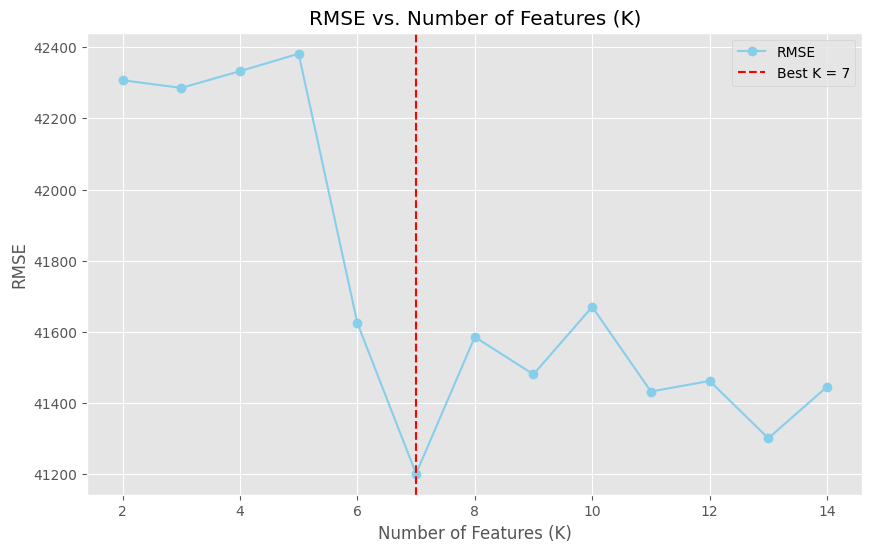

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='skyblue', label='RMSE')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best K = {best_k}')
plt.xlabel('Number of Features (K)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Features (K)')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
selected_features = mrmr_regression(X=X_train, y=y_train, K=best_k)

100%|██████████| 7/7 [00:00<00:00, 32.53it/s]


In [50]:
selected_features

['T', 'avg_outflow', 'BOD', 'TM', 'Tm', 'avg_inflow', 'Am']

In [52]:
df_filtered = df_prep[selected_features]

## Variable Selection

### Checking explained variance

In [53]:
def svd_decomp(x):
  x_scaled = (x - x.mean())/x.std()
  u, s, vh = np.linalg.svd(x_scaled)
  n = x.shape[0]
  variances = s**2 / (n - 1)
  explained_variance_df = pd.DataFrame({
    "Component": [*range(1, len(s)+1)],
    "Variance": variances,
    "Proportion": variances/np.sum(variances),
    "Cumulative": np.cumsum(variances/np.sum(variances))
  })

  return explained_variance_df

In [54]:
scaler = StandardScaler()
features = df_filtered.columns
x = df_filtered.loc[:, features].values
x = scaler.fit_transform(x)

explained_var = svd_decomp(x)

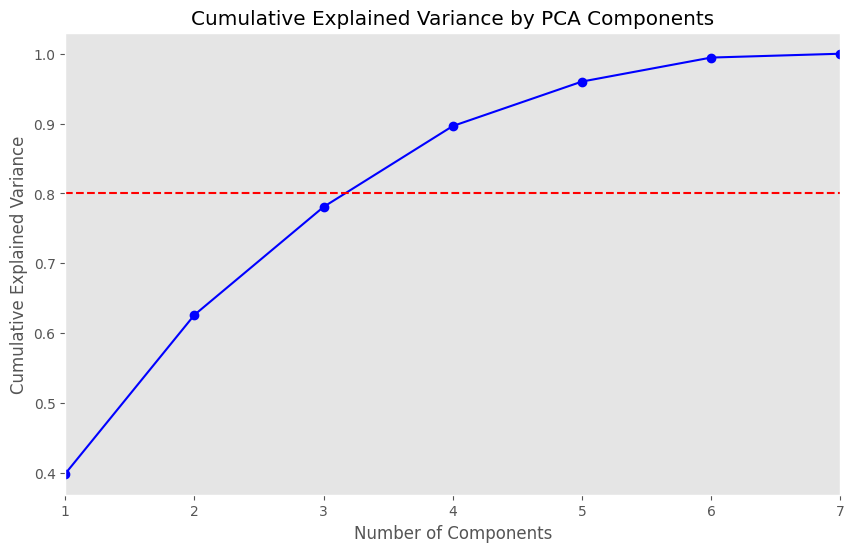

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(explained_var['Component'], explained_var['Cumulative'], marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlim(1,7)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.grid()
plt.show()

In [59]:
explained_var['Cumulative'].iloc[3]

0.8965193781724996

4 components are able to yield more than 80% of the explained variance

### Conventional PCA

In [60]:
def conventional_pca(x,n_components):
  pca = PCA(n_components)
  pca.fit(x)
  x_pca = pca.transform(x)

  #Performing T^2 analysis
  a = n_components
  n = x.shape[0]
  eigenvalues = pca.explained_variance_
  T2 = np.sum((x_pca**2) / eigenvalues, axis=1)

  # Calculating the T^2 limit
  alpha = 0.025  # For 97.5% confidence level
  T2_limit = (a * (n - 1) / (n - a)) * f.ppf(1 - alpha, a, n - a)
  print("T^2 limit:", T2_limit)

  #Performing Q-statistic analysis
  x_reconstructed = pca.inverse_transform(x_pca)
  residuals = x - x_reconstructed
  Q_statistic = np.sum(residuals**2, axis=1)

  #Calculating the Q-statistic limit
  degrees_of_freedom = x.shape[1] - n_components #number of variables free to vary after the pca
  Q_limit = chi2.ppf(1 - alpha, degrees_of_freedom)
  print("Q-statistic limit:", Q_limit)

  return x_pca, T2, T2_limit, Q_statistic, Q_limit

In [62]:
x_pca, T2, T2_lim, Q_statistic, Q_lim  = conventional_pca(x,4)

T^2 limit: 11.204666411565414
Q-statistic limit: 9.348403604496148


In [75]:
dates = pd.to_datetime(df_filtered.index)
outlier_periods_t2 = []
in_period = False
start_date = None
count = 0

for i in range(len(T2)):
    if T2[i] > T2_lim:
        if not in_period:
            start_date = dates[i]
            in_period = True
            count = 1
        else:
            count += 1
    else:
        if in_period:
            if count > 1:
                end_date = dates[i - 1]
                outlier_periods_t2.append((start_date, end_date))
            in_period = False

# Check if the last period extends to the end of the dataset and has more than 1 sample
if in_period and count > 1:
    end_date = dates[len(T2) - 1]
    outlier_periods_t2.append((start_date, end_date))

# Print the periods of high T^2 statistics
print("Quantity of Abnormal periods:", len(outlier_periods_t2))
for start, end in outlier_periods_t2:
    print("Start date of high T^2 period:", start)
    print("End date of high T^2 period:", end)

Quantity of Abnormal periods: 9
Start date of high T^2 period: 2014-01-14 00:00:00
End date of high T^2 period: 2014-01-16 00:00:00
Start date of high T^2 period: 2016-08-22 00:00:00
End date of high T^2 period: 2016-08-23 00:00:00
Start date of high T^2 period: 2016-12-05 00:00:00
End date of high T^2 period: 2016-12-06 00:00:00
Start date of high T^2 period: 2017-01-04 00:00:00
End date of high T^2 period: 2017-01-09 00:00:00
Start date of high T^2 period: 2017-05-25 00:00:00
End date of high T^2 period: 2017-05-29 00:00:00
Start date of high T^2 period: 2017-12-11 00:00:00
End date of high T^2 period: 2017-12-13 00:00:00
Start date of high T^2 period: 2018-03-04 00:00:00
End date of high T^2 period: 2018-03-05 00:00:00
Start date of high T^2 period: 2018-11-20 00:00:00
End date of high T^2 period: 2018-11-22 00:00:00
Start date of high T^2 period: 2019-01-14 00:00:00
End date of high T^2 period: 2019-01-15 00:00:00


In [76]:
#adjusting the dates on the plots
date_samples = df_filtered.index[15::200]  # Starting on the 15th with a step of 200, this was chosen arbitrarily
sample_numbers = date_samples
tick_labels = [date.strftime('%d-%b-%y') for date in sample_numbers] #customizing the tick labels format

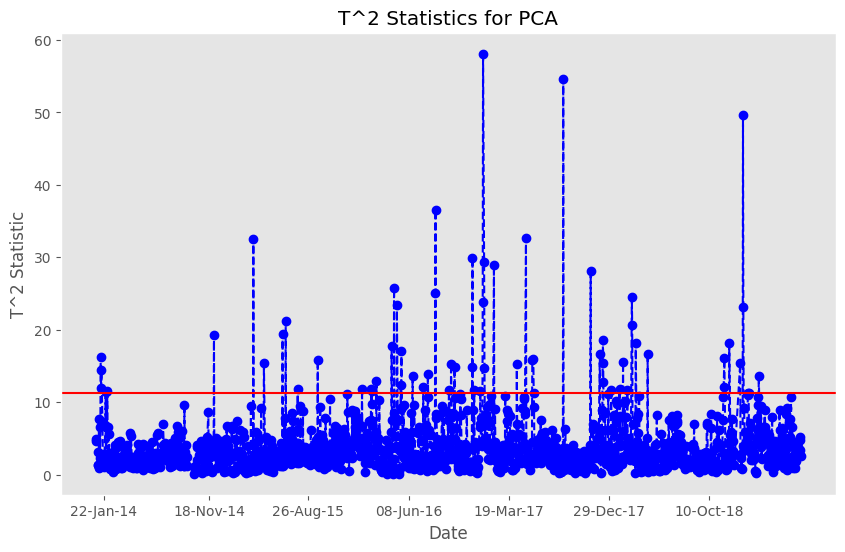

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(dates, T2, marker='o', linestyle='--', color='b')
plt.axhline(y=T2_lim, color='r', linestyle='-')
plt.title('T^2 Statistics for PCA')
plt.xticks(date_samples,tick_labels)
plt.xlabel('Date')
plt.ylabel('T^2 Statistic')
plt.grid()
plt.show()

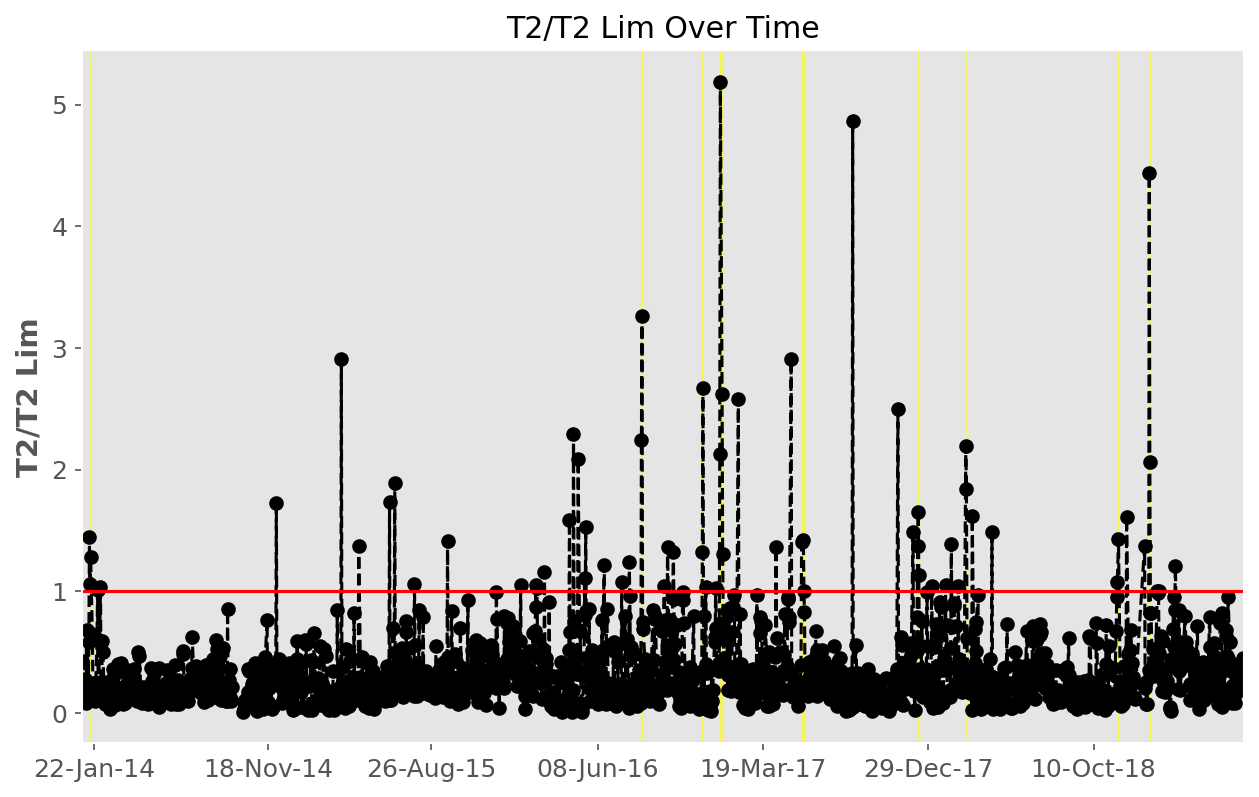

In [66]:
df_T2_ratio = pd.DataFrame({
    'T2/T2_lim': T2 / T2_lim
}, index=dates)

fgs = (10, 6)
plt.figure(figsize=fgs, dpi=150)
plt.plot(df_T2_ratio, color='black', marker='o', linestyle='--')
plt.hlines(1, xmin=df_T2_ratio.index[0], xmax=df_T2_ratio.index[-1], colors='red')

for start, end in outlier_periods_t2:
    plt.axvspan(start, end, ymin=0, ymax=1, color='yellow', alpha=0.5)

plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('T2/T2 Lim', fontsize=14, fontweight='bold')
plt.xticks(date_samples,tick_labels)
plt.tick_params(labelsize=12)
plt.title('T2/T2 Lim Over Time')
plt.grid()
plt.show()

Excluding the samples

In [80]:
if in_period and count > 1:
    end_date = dates[len(T2) - 1]
    outlier_periods_t2.append((start_date, end_date))

# Create a mask to exclude samples within the outlier periods
mask = pd.Series([True] * len(df_filtered), index=df_filtered.index)

for start, end in outlier_periods_t2:
    mask &= ~((df_filtered.index >= start) & (df_filtered.index <= end))

# Filter the DataFrame to exclude the outliers
df_filtered_cpca = df_filtered[mask]

# Print the result
print("Original DataFrame shape:", df_filtered.shape)
print("Filtered DataFrame shape:", df_filtered_cpca.shape)

Original DataFrame shape: (1382, 7)
Filtered DataFrame shape: (1359, 7)


In [68]:
outlier_periods_q = []
in_period = False
start_date = None
count = 0

for i in range(len(Q_statistic)):
    if Q_statistic[i] > Q_lim:
        if not in_period:
            start_date = dates[i]
            in_period = True
            count = 1
        else:
            count += 1
    else:
        if in_period:
            if count > 1:
                end_date = dates[i - 1]
                outlier_periods_q.append((start_date, end_date))
            in_period = False

# Check if the last period extends to the end of the dataset and has more than 2 samples
if in_period and count > 1:
    end_date = dates[len(Q_statistic) - 1]
    outlier_periods_q.append((start_date, end_date))

# Print the periods of high Q statistics
print("Quantity of Abnormal periods:", len(outlier_periods_q))
for start, end in outlier_periods_q:
    print("Start date of high Q-statistic period:", start)
    print("End date of high Q-statistic period:", end)

Quantity of Abnormal periods: 1
Start date of high Q-statistic period: 2016-08-22 00:00:00
End date of high Q-statistic period: 2016-08-23 00:00:00


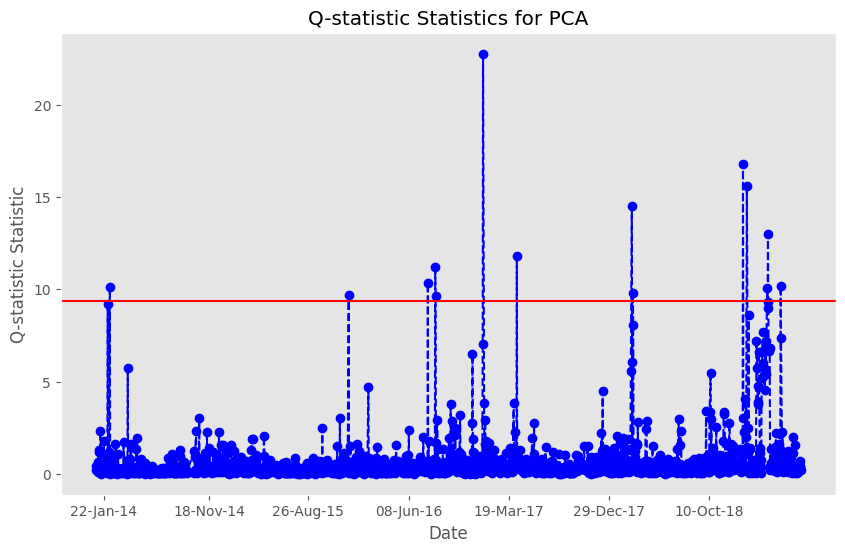

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(dates, Q_statistic, marker='o', linestyle='--', color='b')
plt.axhline(y=Q_lim, color='r', linestyle='-')  # Add horizontal line at T^2 limit
plt.title('Q-statistic Statistics for PCA')
plt.xticks(date_samples,tick_labels)
plt.xlabel('Date')
plt.ylabel('Q-statistic Statistic')
plt.grid()
plt.show()

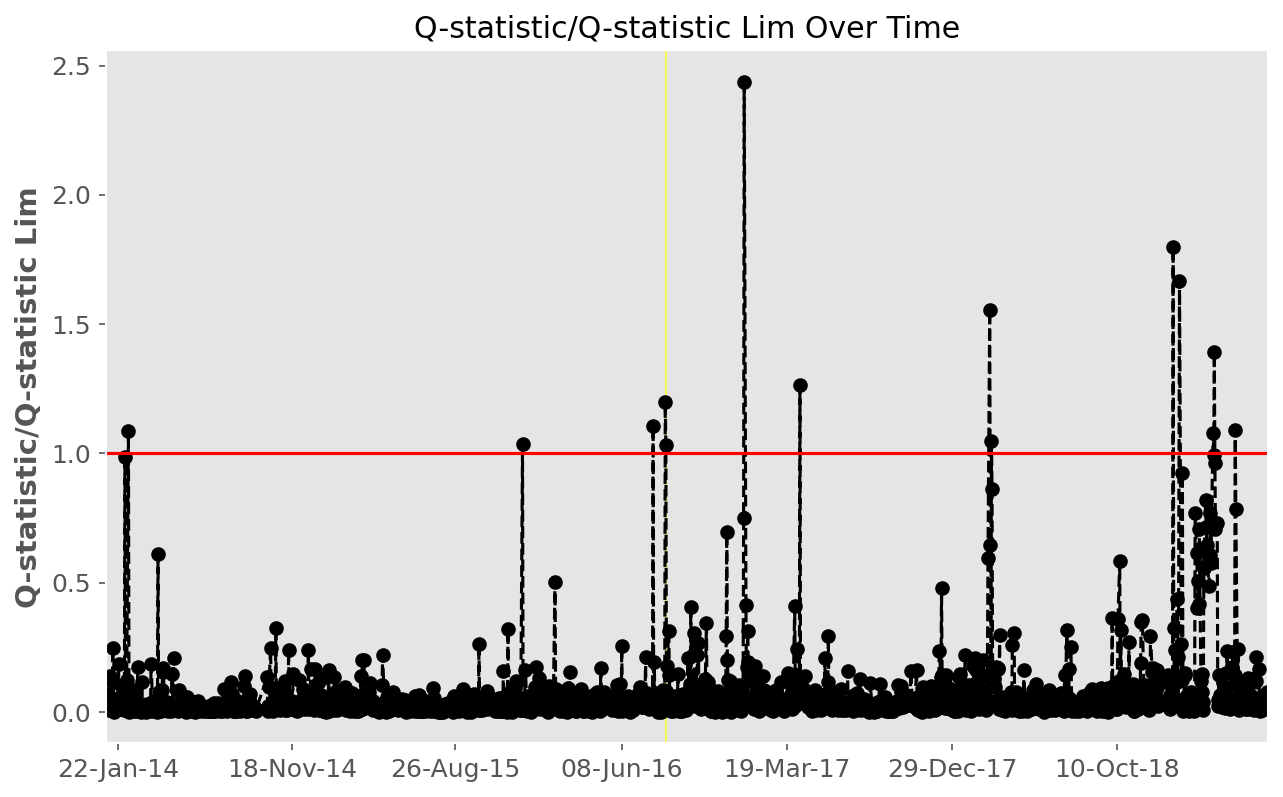

In [70]:
df_Q_ratio = pd.DataFrame({
    'Q/Q_lim': Q_statistic / Q_lim
}, index=dates)

plt.figure(figsize=(10,6), dpi=150)
plt.plot(df_Q_ratio, color='black', marker='o', linestyle='--')
plt.hlines(1, xmin=df_Q_ratio.index[0], xmax=df_Q_ratio.index[-1], colors='red')

for start, end in outlier_periods_q:
    plt.axvspan(start, end, ymin=0, ymax=1, color='yellow', alpha=0.5)

plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Q-statistic/Q-statistic Lim', fontsize=14, fontweight='bold')
plt.xticks(date_samples,tick_labels)
plt.tick_params(labelsize=12)
plt.title('Q-statistic/Q-statistic Lim Over Time')
plt.grid()
plt.show()

In [81]:
if in_period and count > 1:
    end_date = dates[len(Q_statistic) - 1]
    outlier_periods_q.append((start_date, end_date))

# Create a mask to exclude samples within the outlier periods
mask = pd.Series([True] * len(df_filtered), index=df_filtered.index)

for start, end in outlier_periods_q:
    mask &= ~((df_filtered.index >= start) & (df_filtered.index <= end))

# Filter the DataFrame to exclude the outliers
df_filtered_cpca = df_filtered_cpca[mask]

# Print the result
print("Original DataFrame shape:", df_filtered.shape)
print("Filtered DataFrame shape:", df_filtered_cpca.shape)

Original DataFrame shape: (1382, 7)
Filtered DataFrame shape: (1359, 7)


In [72]:
y_aligned = y.loc[df_filtered_cpca.index]

## Final pre-processing

In [74]:
df_filtered_scaled = scaling(df_filtered_cpca)

# Train and test datasets

In [92]:
df_Y = y.copy()

df_Y_filtered = df_Y.loc[df_filtered_cpca.index]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered_scaled, df_Y_filtered, test_size=0.25, shuffle=False)

# Modelling 

## OLS

In [94]:
y_pred_ols, ols_model = ols_regression(X_train, y_train, X_test)
print_metrics(y_test, y_pred_ols, "OLS Regression")

OLS Regression - RMSE: 44063.6006, R²: -0.1503


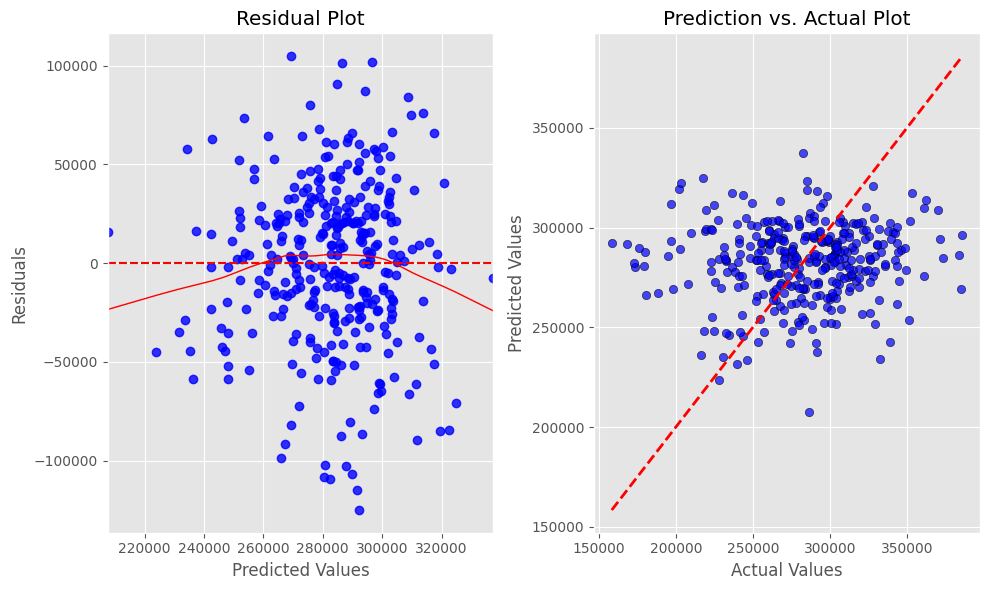

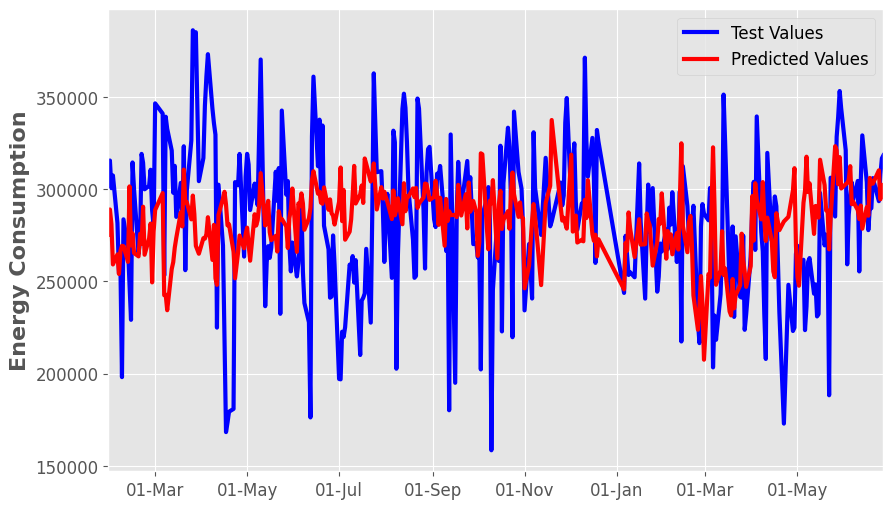

In [95]:
plot_res(fgs,y_test,y_pred_ols)
print('\n')
plot_ts(fgs, y_test, y_pred_ols, 'Energy Consumption')

## Moving Window OLS

In [98]:
window_sizes = range(1, 8)
results = []

for size in window_sizes:
    rmse, r2 = evaluate_moving_window(df_filtered_scaled, df_Y_filtered, size)
    results.append((size, rmse, r2))

best_window = min(results, key=lambda x: x[1])
print(f'\n Best Window Size: {best_window[0]}, RMSE: {best_window[1]:.4f}, R²: {best_window[2]:.4f}')

Iteration 7: 100%|██████████| 1352/1352 [00:00<00:00, 1552.00it/s]


 Best Window Size: 1, RMSE: 40266.7148, R²: 0.1795


In [99]:
size = best_window[0]
y_pred_moving_window_ols = moving_window_ols(df_filtered_scaled, df_Y_filtered, size)
print_metrics(
    df_Y_filtered.iloc[size:],
    y_pred_moving_window_ols[size:],
    "Moving Window OLS Regression"
)

Moving Window OLS Regression - RMSE: 40266.7148, R²: 0.1795


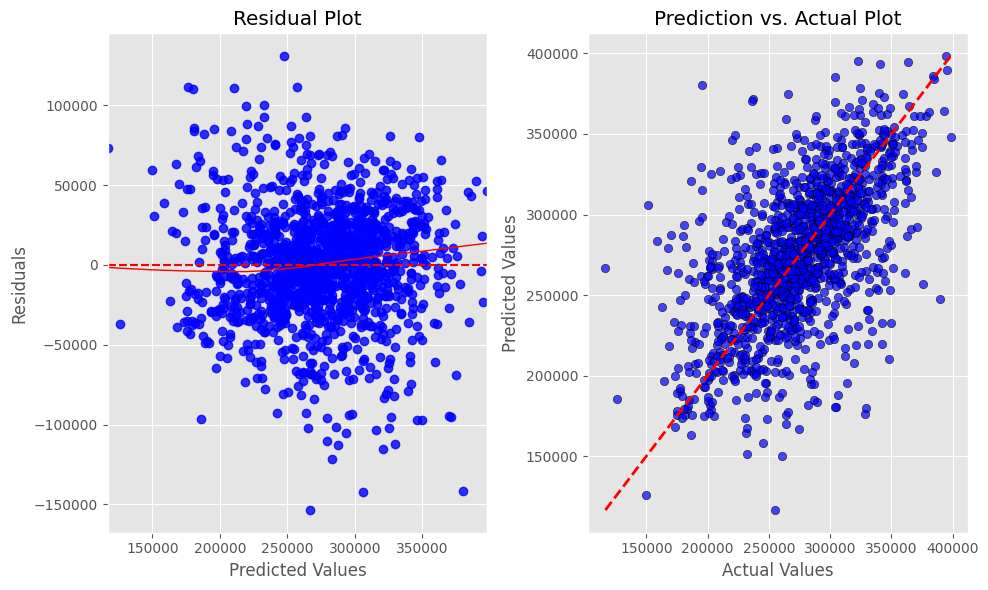

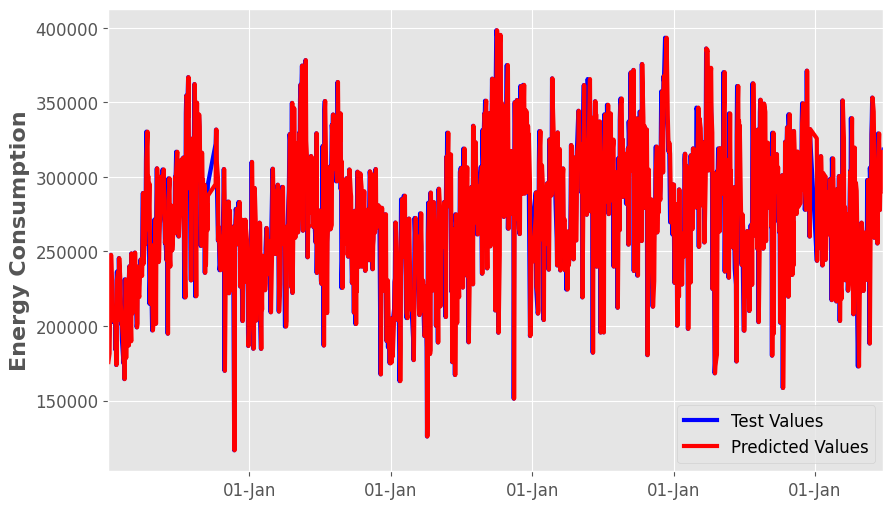

In [101]:
plot_res(fgs,df_Y_filtered[size:],y_pred_moving_window_ols[size:])
print('\n')
plot_ts(fgs, df_Y_filtered[size:], y_pred_moving_window_ols[size:], 'Energy Consumption')

## Ridge Regression

In [112]:
alpha_values = np.linspace(100, 200, 50)

ridge = Ridge()
ridge_params = {'alpha': alpha_values}
ridge_grid_search = GridSearchCV(ridge, ridge_params, scoring='r2', cv=5)
ridge_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([100.        , 102.04081633, 104.08163265, 106.12244898,
       108.16326531, 110.20408163, 112.24489796, 114.28571429,
       116.32653061, 118.36734694, 120.40816327, 122.44897959,
       124.48979592, 126.53061224, 128.57142857, 130.6122449 ,
       132.65306122, 134.69387755, 136.73469388, 138.7755102 ,
       140.81632653, 142.85714286, 144.8979591...77551,
       148.97959184, 151.02040816, 153.06122449, 155.10204082,
       157.14285714, 159.18367347, 161.2244898 , 163.26530612,
       165.30612245, 167.34693878, 169.3877551 , 171.42857143,
       173.46938776, 175.51020408, 177.55102041, 179.59183673,
       181.63265306, 183.67346939, 185.71428571, 187.75510204,
       189.79591837, 191.83673469, 193.87755102, 195.91836735,
       197.95918367, 200.        ])},
             scoring='r2')

In [113]:
best_ridge_alpha = ridge_grid_search.best_params_['alpha']
ridge_best_model = ridge_grid_search.best_estimator_
y_pred_ridge_best = ridge_best_model.predict(X_test)
print(f'Best Ridge Alpha: {best_ridge_alpha}')
print_metrics(y_test, y_pred_ridge_best, "Best Ridge Regression")

Best Ridge Alpha: 100.0
Best Ridge Regression - RMSE: 42365.0327, R²: -0.0633


In [114]:
y_pred_ridge, ridge_model = ridge_regression(X_train, y_train, X_test, best_ridge_alpha)
print_metrics(y_test, y_pred_ridge, "Ridge Regression")

Ridge Regression - RMSE: 42365.0327, R²: -0.0633


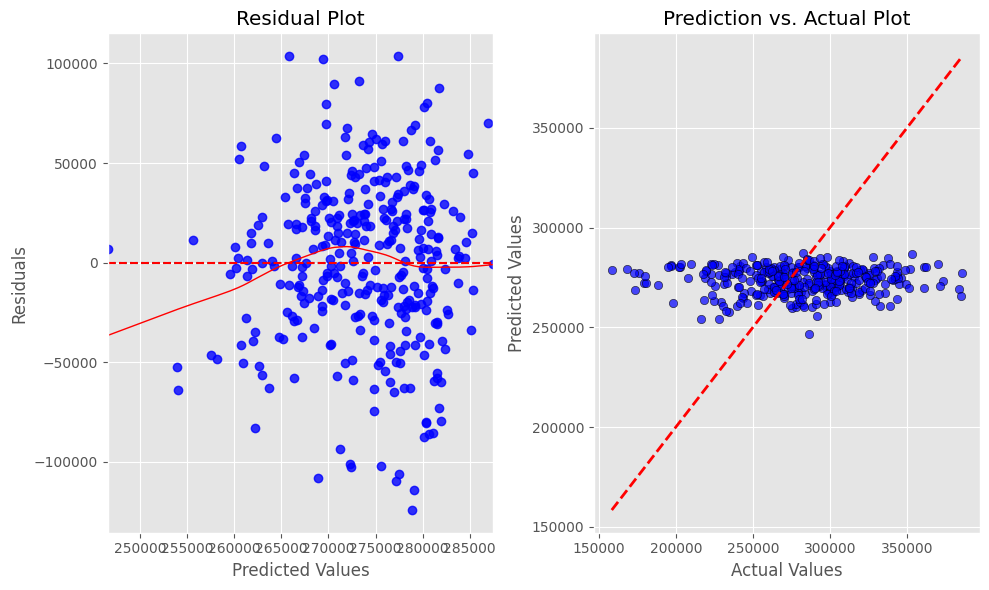

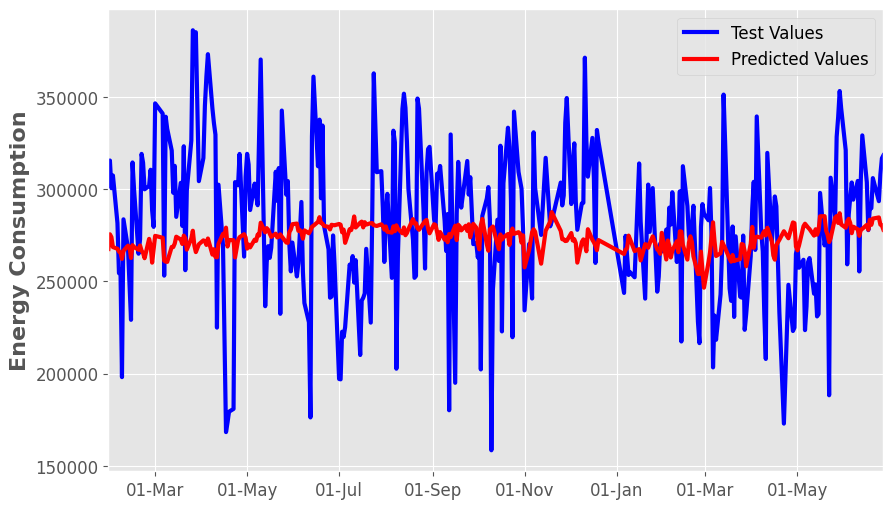

In [115]:
plot_res(fgs,y_test,y_pred_ridge)
print('\n')
plot_ts(fgs, y_test, y_pred_ridge, 'Energy Consumption')

## Moving Window Ridge Regression

In [116]:
y_pred_ridge = moving_window_ridge(df_filtered_scaled, df_Y_filtered, window_size=7, alpha=best_ridge_alpha)
print_metrics(df_Y_filtered[7:], y_pred_ridge[7:], "Ridge Regression with Moving Window")

Ridge Regression with Moving Window - RMSE: 37181.3485, R²: 0.2963


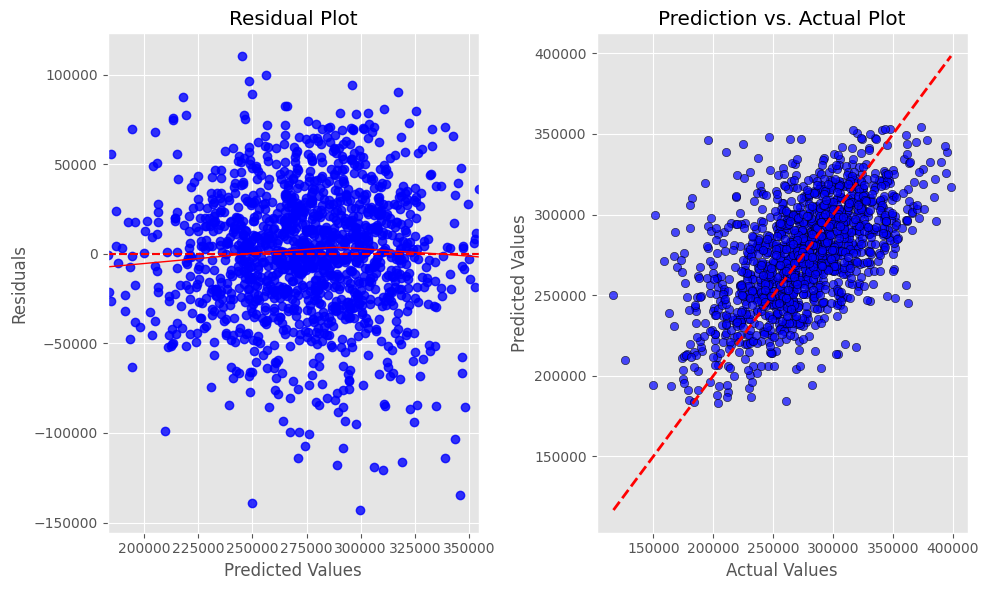

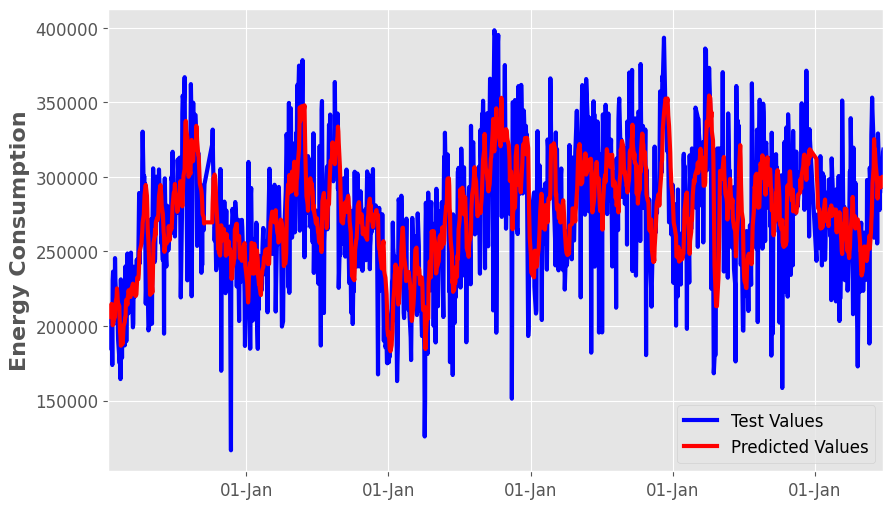

In [119]:
plot_res(fgs,df_Y_filtered[7:],y_pred_ridge[7:])
print('\n')
plot_ts(fgs, df_Y_filtered[7:], y_pred_ridge[7:], 'Energy Consumption')

## Lasso Regression 

In [128]:
alpha_values = np.linspace(0, 20, 50)
lasso = Lasso(max_iter=10000)
lasso_params = {'alpha': alpha_values}
lasso_grid_search = GridSearchCV(lasso, lasso_params, scoring='r2', cv=5)
lasso_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
        2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
        4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
        6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
        8.16326531,  8.57142857,  8.97959184,  9.3877551 ,  9.79591837,
       10.20408163, 10.6122449 , 11.02040816, 11.42857143, 11.83673469,
       12.24489796, 12.65306122, 13.06122449, 13.46938776, 13.87755102,
       14.28571429, 14.69387755, 15.10204082, 15.51020408, 15.91836735,
       16.32653061, 16.73469388, 17.14285714, 17.55102041, 17.95918367,
       18.36734694, 18.7755102 , 19.18367347, 19.59183673, 20.        ])},
             scoring='r2')

In [129]:
best_lasso_alpha = lasso_grid_search.best_params_['alpha']
lasso_best_model = lasso_grid_search.best_estimator_
y_pred_lasso_best = lasso_best_model.predict(X_test)
print(f'Best Lasso Alpha: {best_lasso_alpha}')
print_metrics(y_test, y_pred_lasso_best, "Best Lasso Regression")

Best Lasso Alpha: 6.122448979591837
Best Lasso Regression - RMSE: 44022.1606, R²: -0.1481


In [130]:
y_pred_lasso, lasso_model = lasso_regression(X_train, y_train, X_test, best_lasso_alpha)
print_metrics(y_test, y_pred_lasso, "Lasso Regression")

Lasso Regression - RMSE: 44022.1606, R²: -0.1481


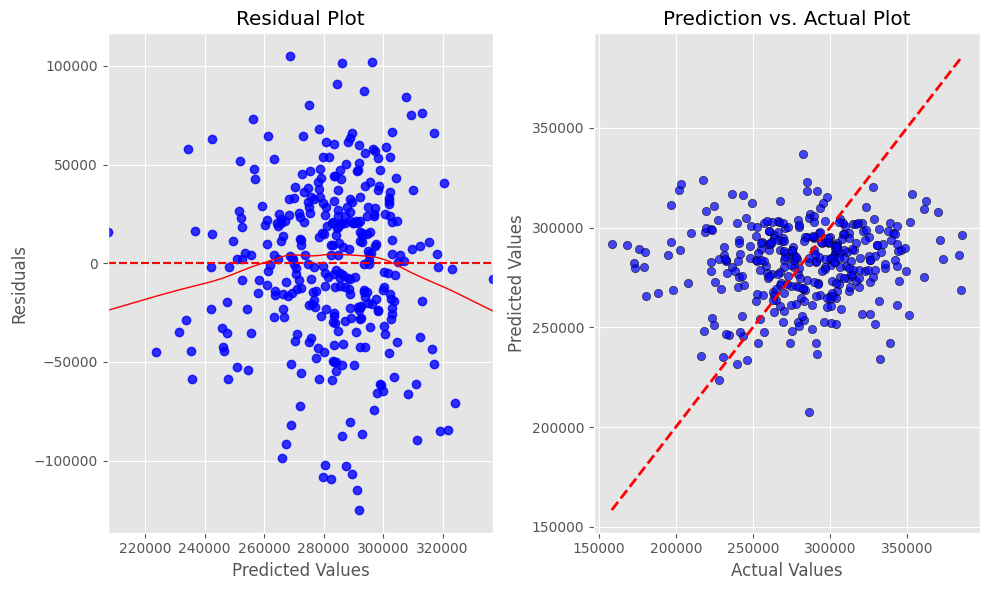

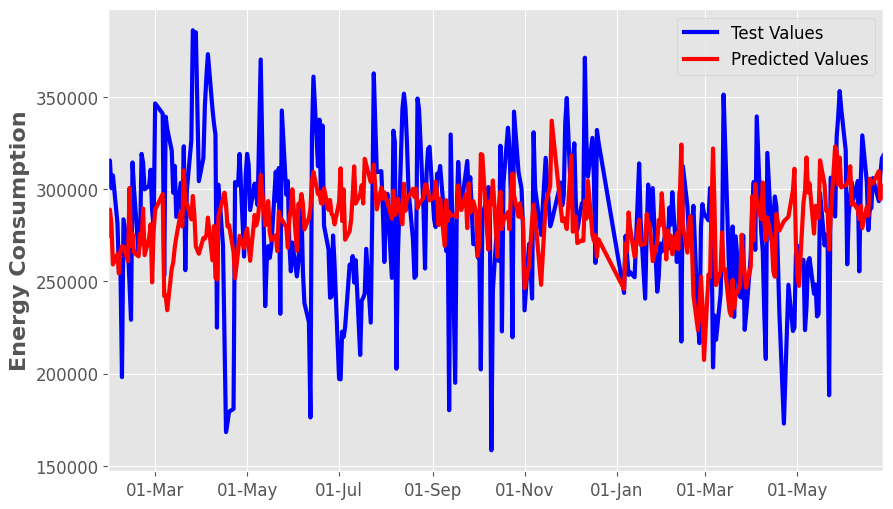

In [131]:
plot_res(fgs,y_test,y_pred_lasso)
print('\n')
plot_ts(fgs, y_test, y_pred_lasso, 'Energy Consumption')

## Moving Window Lasso Regression

In [136]:
y_pred_lasso = moving_window_lasso(df_filtered_scaled, df_Y_filtered, window_size=30*6, alpha=best_lasso_alpha)
print_metrics(df_Y_filtered[30*6:], y_pred_lasso[30*6:], "Lasso Regression with Moving Window")

Lasso Regression with Moving Window - RMSE: 42254.0378, R²: 0.0700


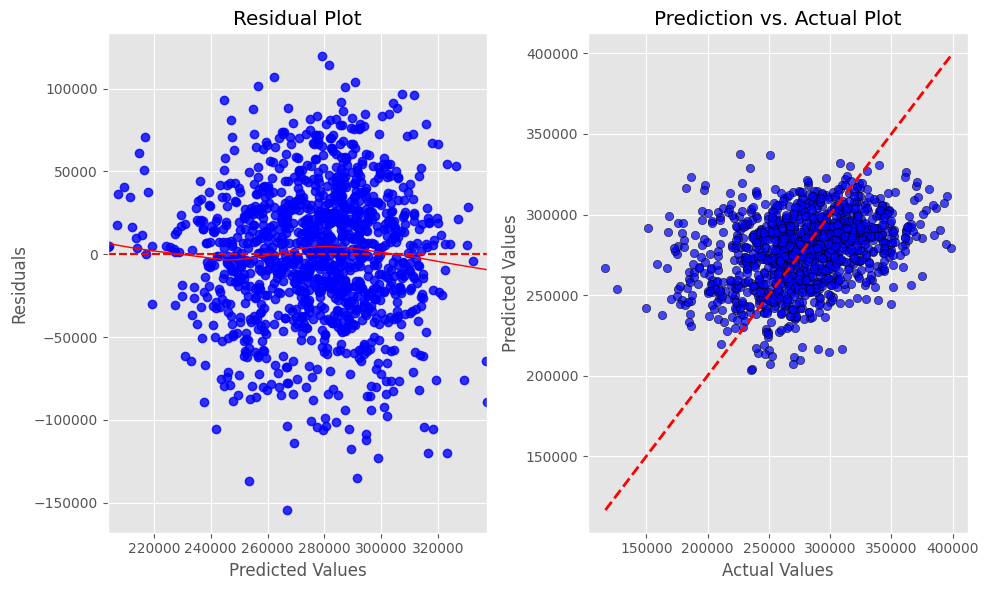

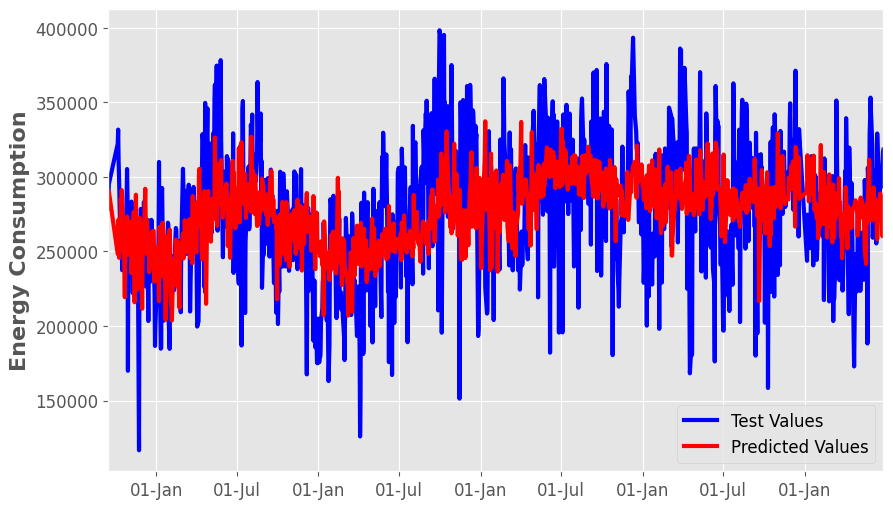

In [137]:
plot_res(fgs,df_Y_filtered[30*6:],y_pred_lasso[30*6:])
print('\n')
plot_ts(fgs, df_Y_filtered[30*6:], y_pred_lasso[30*6:], 'Energy Consumption')

## PLS

In [140]:
components_range = range(1, 9)

r2_scores = []
rmse_scores = []
best_r2 = -float('inf')  # Initialize with a very low value
best_component = None

for n_components in components_range:
    y_pred_pls, pls_model = pls_regression(X_train, y_train, X_test, n_components)
    r2 = r2_score(y_test, y_pred_pls)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_pls))
    r2_scores.append(r2)
    rmse_scores.append(rmse)

    if r2 > best_r2:
        best_r2 = r2
        best_component = n_components


    print(f"Components: {n_components}, R²: {r2:.4f}, RMSE: {rmse:.4f}")

Components: 1, R²: -0.1564, RMSE: 44181.3167
Components: 2, R²: -0.1587, RMSE: 44224.9768
Components: 3, R²: -0.1654, RMSE: 44352.0387
Components: 4, R²: -0.1499, RMSE: 44056.2045
Components: 5, R²: -0.1555, RMSE: 44163.6866
Components: 6, R²: -0.1499, RMSE: 44056.6689
Components: 7, R²: -0.1431, RMSE: 43927.2746
Components: 8, R²: -0.1465, RMSE: 43990.7895


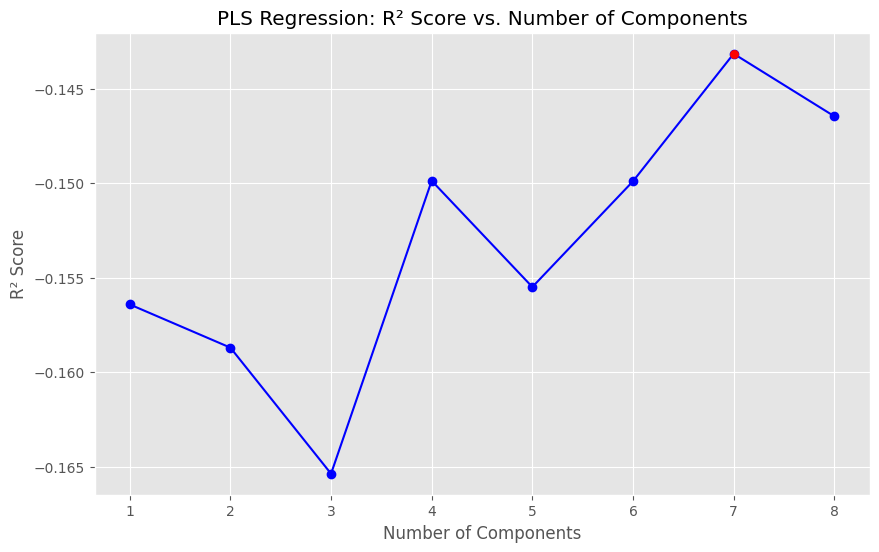

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(components_range, r2_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.title('PLS Regression: R² Score vs. Number of Components')
plt.scatter(best_component, best_r2, color='red', zorder=5, label=f'Highest R² ({best_r2:.4f})')
plt.grid(True)
plt.show()

In [142]:
y_pred_pls, pls_model = pls_regression(X_train, y_train, X_test, best_component)
print_metrics(y_test, y_pred_pls, "PLS Regression")

PLS Regression - RMSE: 43927.2746, R²: -0.1431


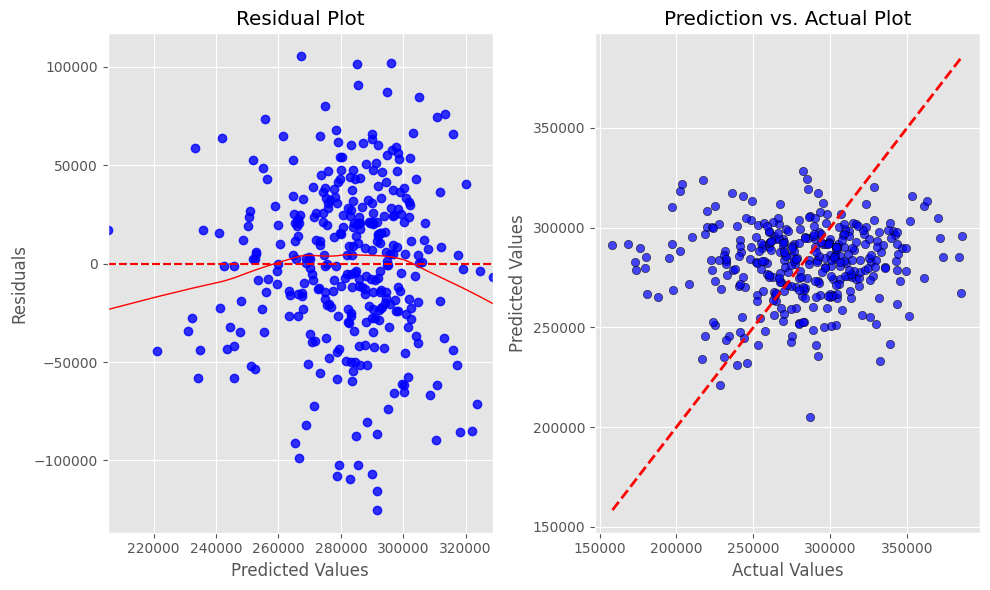

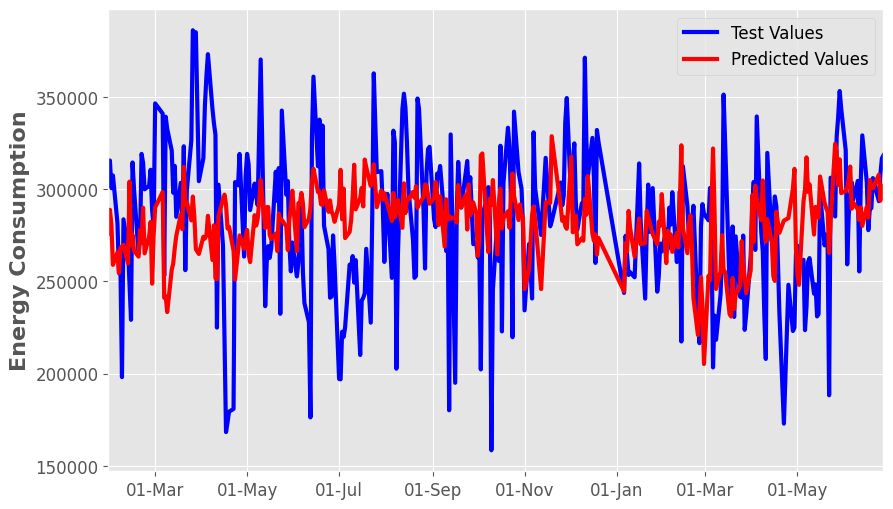

In [143]:
plot_res(fgs,y_test,y_pred_pls)
print('\n')
plot_ts(fgs, y_test, y_pred_pls, 'Energy Consumption')

## Adaboost

In [150]:
# Initialize the base model for AdaBoost
base_model = DecisionTreeRegressor(max_depth=10)

# Initialize AdaBoost with the base model
adaboost = AdaBoostRegressor(base_model)
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35],
    'learning_rate': [0.001, 0.005, 0.01]
}

In [151]:
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score (R²): {best_score}")

Best Parameters: {'learning_rate': 0.001, 'n_estimators': 35}
Best Score (R²): -0.0061313059335216915


In [152]:
best_model = grid_search.best_estimator_
y_pred_ada = best_model.predict(X_test)
print_metrics(y_test, y_pred_ada, "AdaBoost")

AdaBoost - RMSE: 43621.9326, R²: -0.1273


## XGBoost - to be performed

## Random Forest

In [153]:
best_model, best_params = rf_grid_search(X_train, y_train)
print("Best parameters:", best_params)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}


In [154]:
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=20)

In [155]:
y_pred_rf = best_rf.predict(X_test)
print_metrics(y_test, y_pred_rf, "Random Forest")

Random Forest - RMSE: 43455.1339, R²: -0.1187


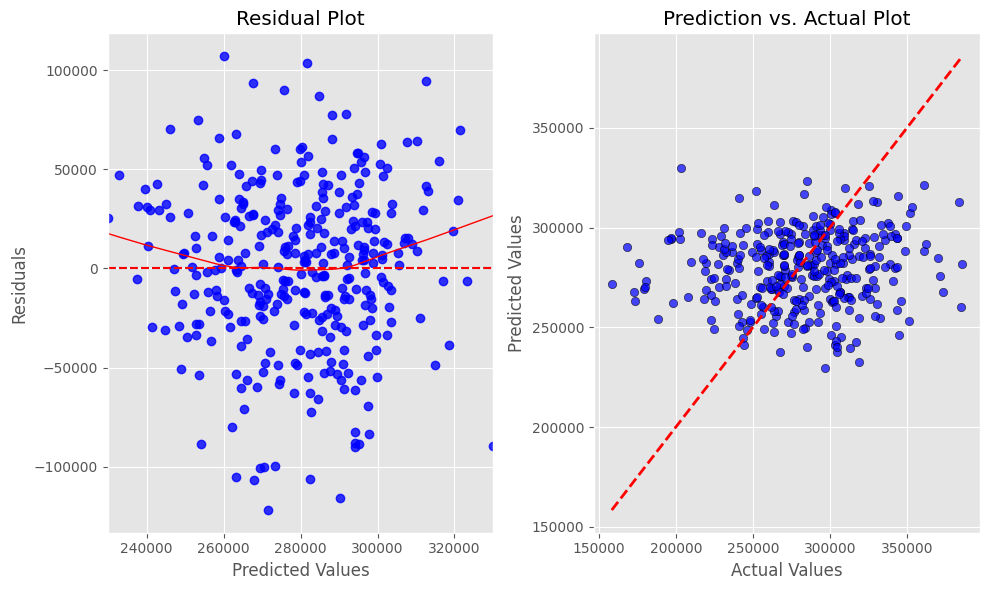

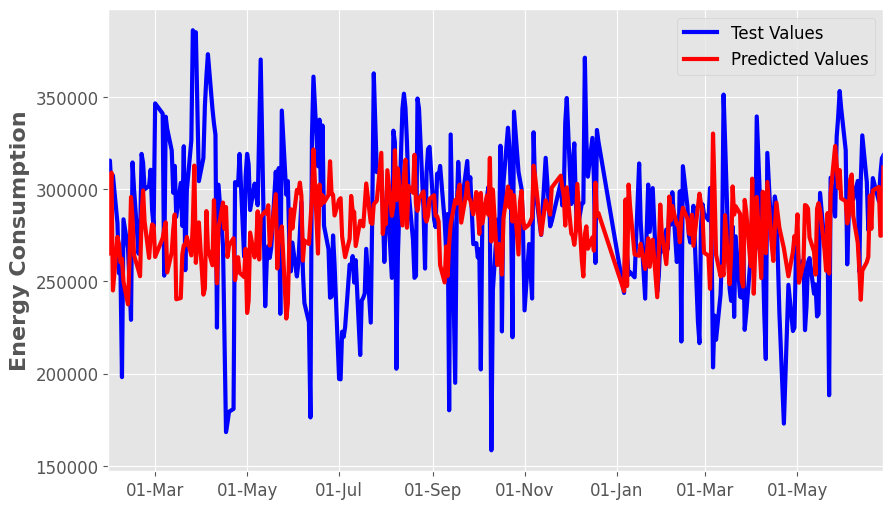

In [156]:
plot_res(fgs,y_test,y_pred_rf)
print('\n')
plot_ts(fgs, y_test, y_pred_rf, 'Energy Consumption')

## Moving Window Random Forest

In [160]:
y_true, y_pred_rf, rmse_list = rolling_window_random_forest(df_filtered_scaled, df_Y_filtered, best_params, 7)
average_rmse = np.mean(rmse_list)
r2 = r2_score(y_true, y_pred_rf)
print(f'Average RMSE with moving window: {average_rmse:.4f}')
print(f'R^2 with moving window: {r2:.4f}')

Average RMSE with moving window: 28847.5751
R^2 with moving window: 0.2823


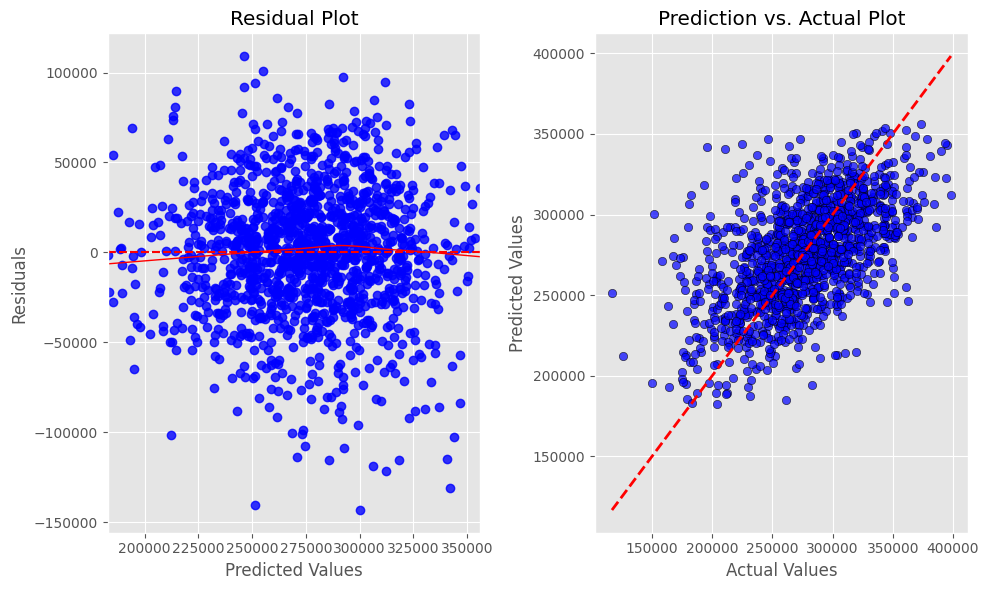

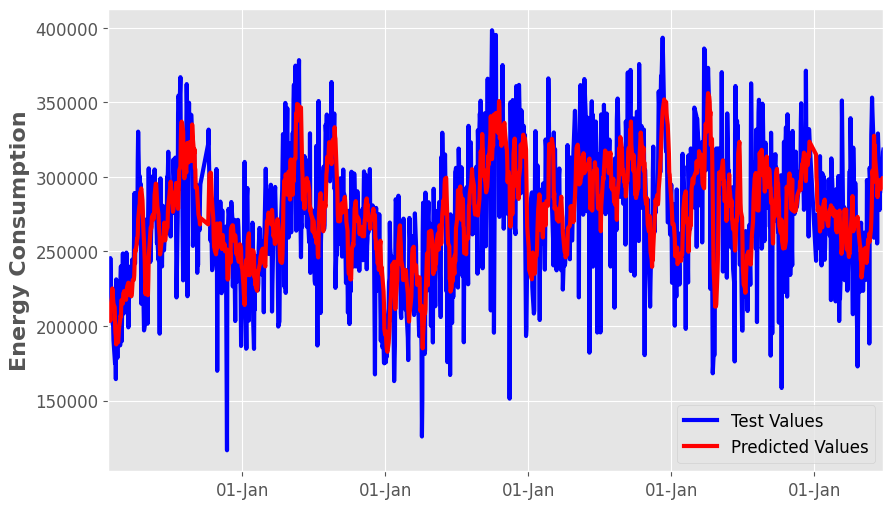

In [164]:
plot_res(fgs,df_Y_filtered[14:],y_pred_rf)
print('\n')
plot_ts(fgs, df_Y_filtered[14:], y_pred_rf, 'Energy Consumption')

## KNN

In [167]:
best_knn, best_params_knn = knn_grid_search(X_train, y_train)
print("Best parameters:", best_params_knn)

y_pred_knn = best_knn.predict(X_test)
print_metrics(y_test, y_pred_knn, "KNN")

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best parameters: {'n_neighbors': 30}
KNN - RMSE: 44060.8491, R²: -0.1501


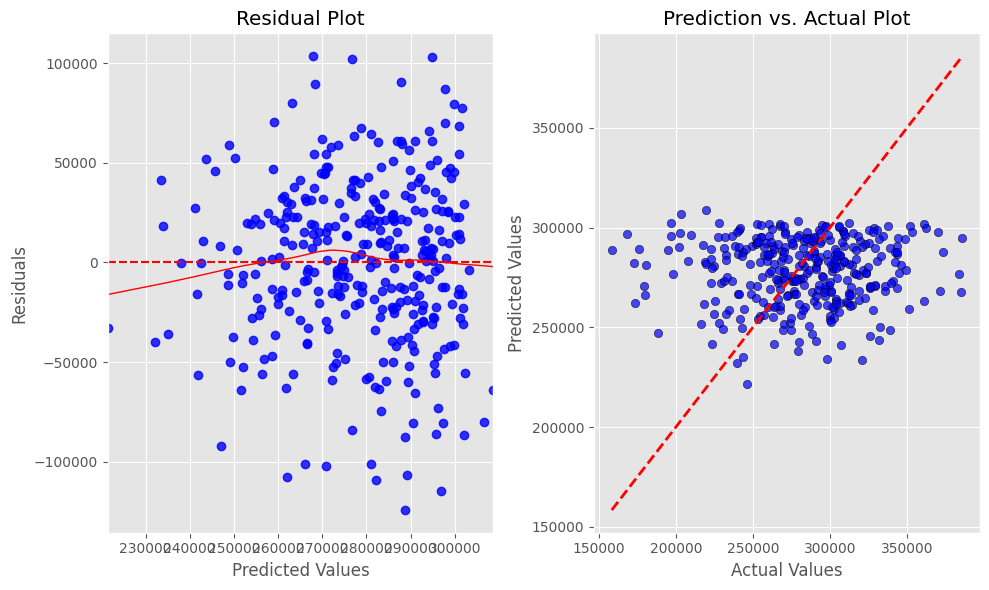

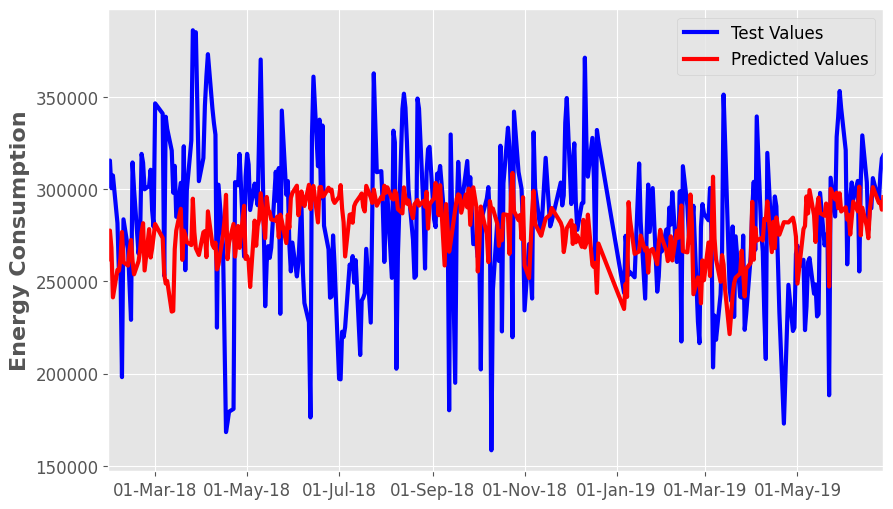

In [171]:
plot_res(fgs,y_test,y_pred_knn)
print('\n')
plot_ts(fgs, y_test, y_pred_knn, 'Energy Consumption')

## Moving Window KNN

In [176]:
y_true, y_pred_knn, rmse_list = moving_window_knn(df_filtered_scaled, df_Y_filtered, 28*6, 49)
average_rmse = np.mean(rmse_list)
r2 = r2_score(y_true, y_pred_knn)
print(f'Average RMSE with moving window: {average_rmse:.4f}')
print(f'R^2 with moving window: {r2:.4f}')

Average RMSE with moving window: 32143.0430
R^2 with moving window: 0.1026


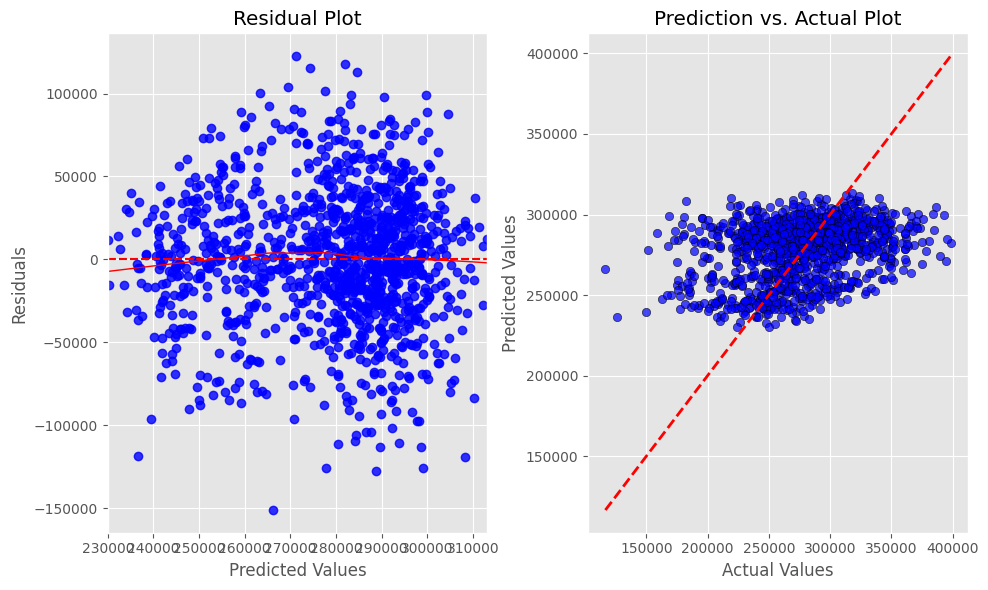

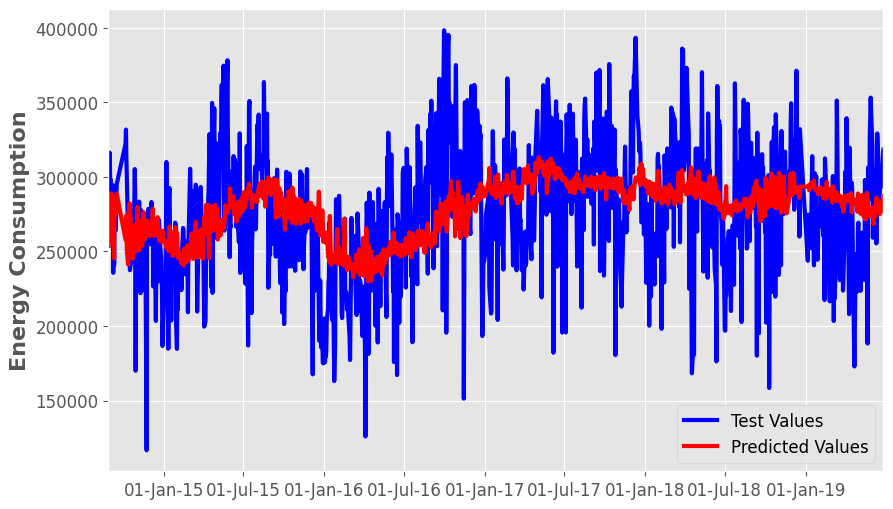

In [177]:
plot_res(fgs,df_Y_filtered[28*6:],y_pred_knn)
print('\n')
plot_ts(fgs, df_Y_filtered[28*6:], y_pred_knn, 'Energy Consumption')

## Huber Regression

In [178]:
y_pred_huber, model = huber_regression(X_train, y_train)
print_metrics(y_test, y_pred_huber, "Huber Regression")

Huber Regression - RMSE: 43622.0208, R²: -0.1273


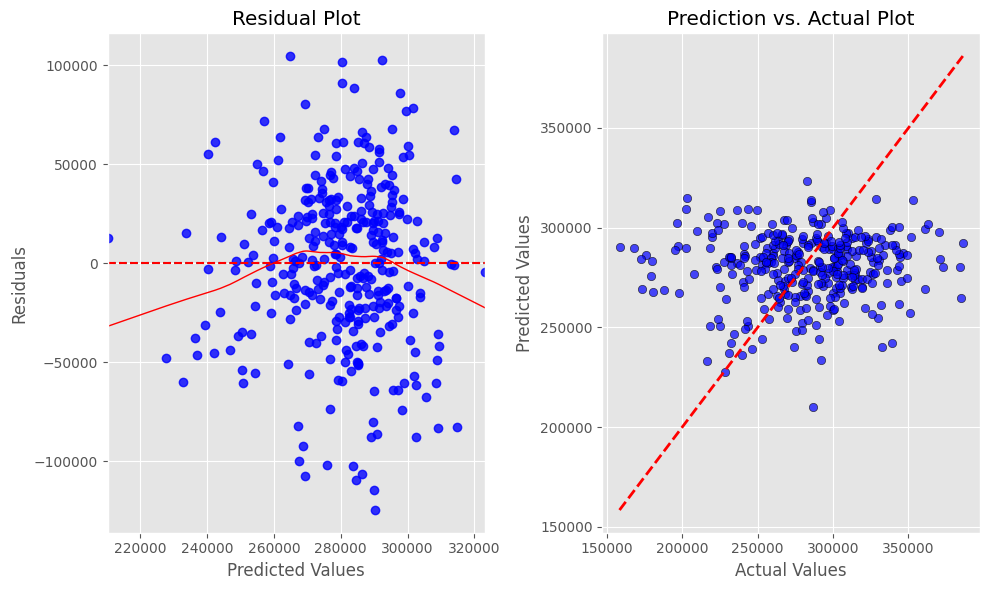

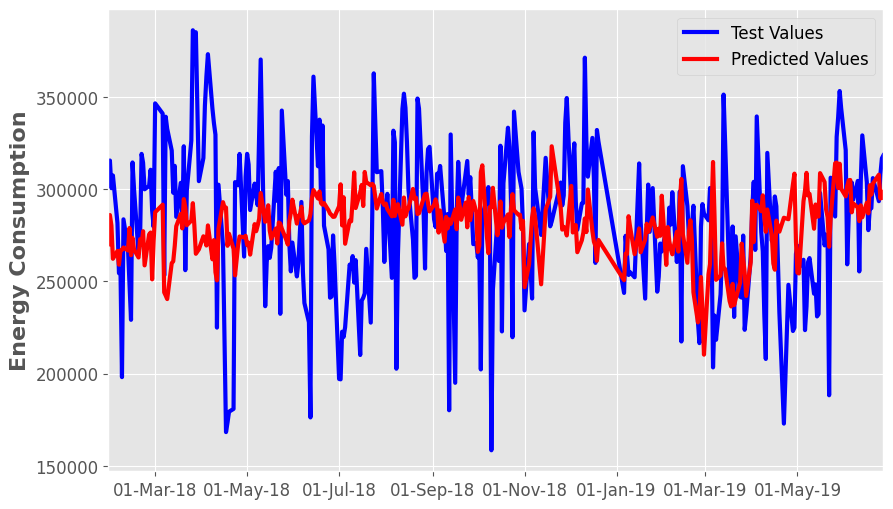

In [179]:
plot_res(fgs,y_test,y_pred_huber)
print('\n')
plot_ts(fgs, y_test, y_pred_huber, 'Energy Consumption')

## Moving Window Huber Regression

In [182]:
y_true, y_pred_huber, rmse_list = moving_window_huber(df_filtered_scaled, df_Y_filtered, 7)
average_rmse = np.mean(rmse_list)
r2 = r2_score(y_true, y_pred_huber)
print(f'Average RMSE with moving window: {average_rmse:.4f}')
print(f'R^2 with moving window: {r2:.4f}')

Average RMSE with moving window: 28687.9114
R^2 with moving window: 0.2864


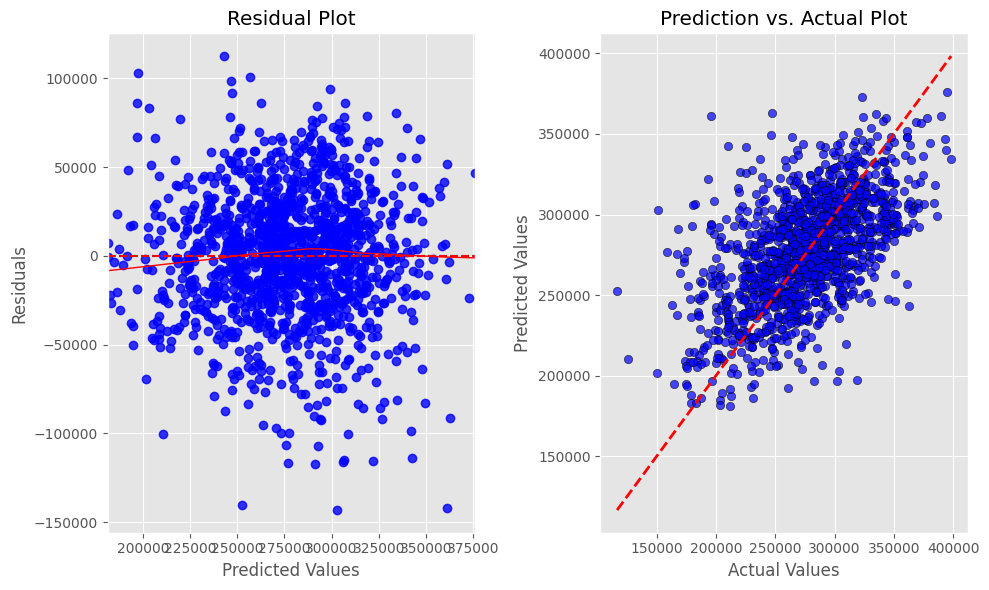

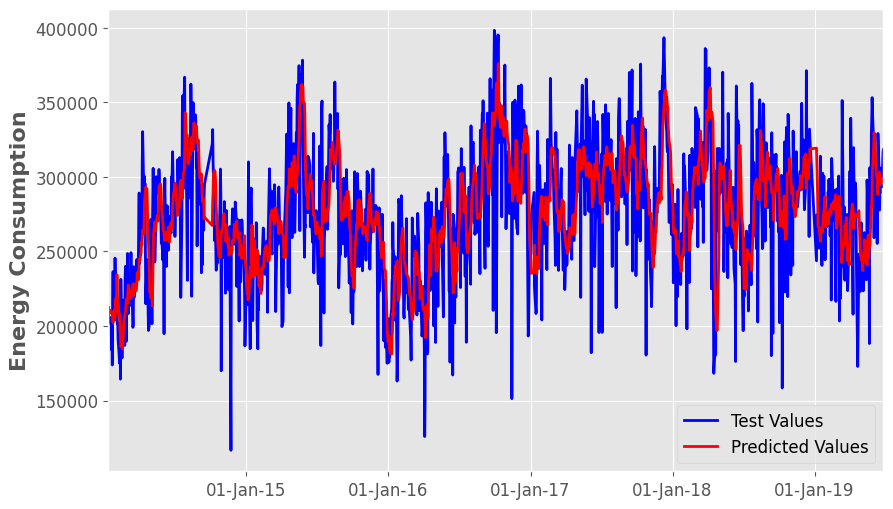

In [185]:
plot_res(fgs,df_Y_filtered[7:],y_pred_huber)
print('\n')
plot_ts(fgs, df_Y_filtered[7:], y_pred_huber, 'Energy Consumption')

## Bayesian Regression

In [186]:
y_pred_bayes, model_bayes = bayesian_regression(X_train, y_train)
print_metrics(y_test, y_pred_bayes, "Bayes Regression")

Bayes Regression - RMSE: 43909.1178, R²: -0.1422


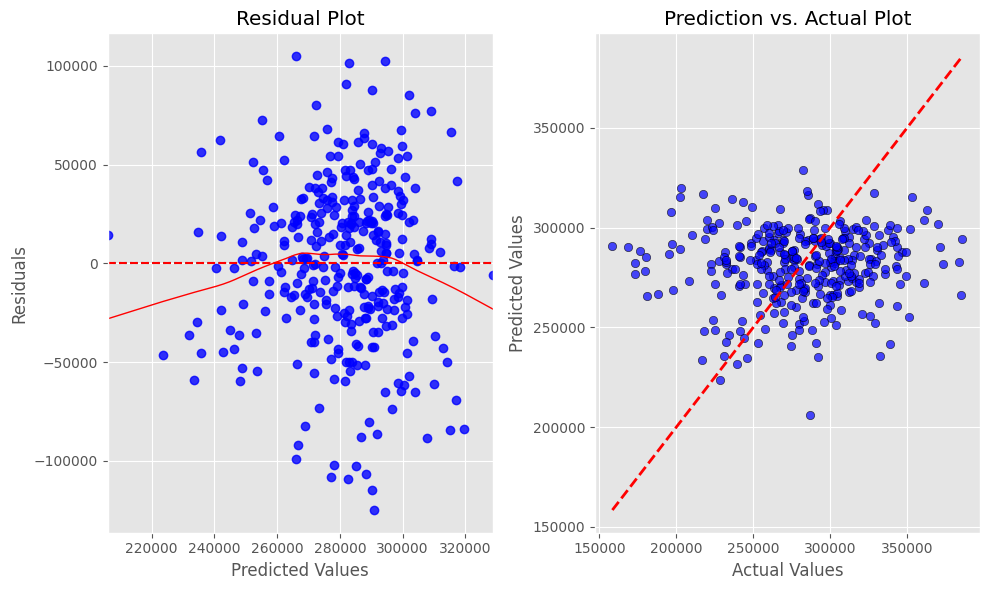

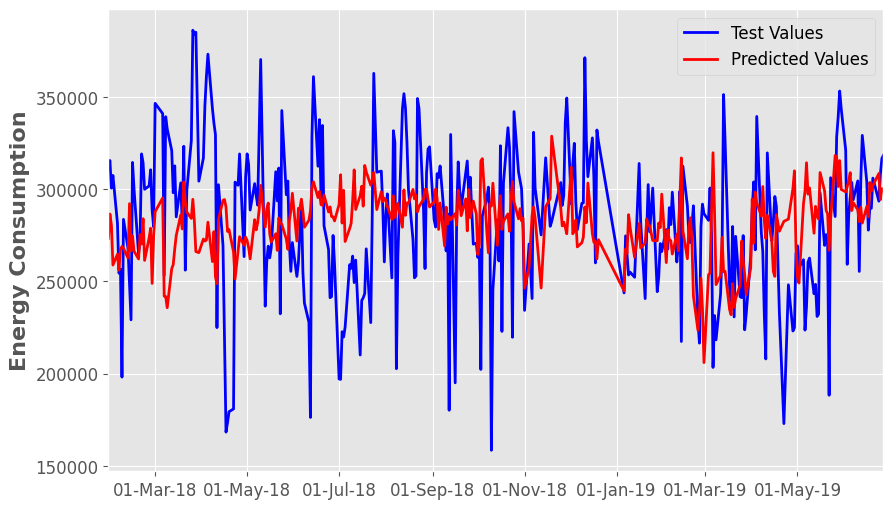

In [187]:
plot_res(fgs,y_test,y_pred_bayes)
print('\n')
plot_ts(fgs, y_test, y_pred_bayes, 'Energy Consumption')

## Moving Window Bayesian Regression

In [191]:
y_true, y_pred_bayes, rmse_list = moving_window_bayesian(df_filtered_scaled, df_Y_filtered, 14)
average_rmse = np.mean(rmse_list)
r2 = r2_score(y_true, y_pred_bayes)
print(f'Average RMSE with moving window: {average_rmse:.4f}')
print(f'R^2 with moving window: {r2:.4f}')

Average RMSE with moving window: 29451.3738
R^2 with moving window: 0.2528


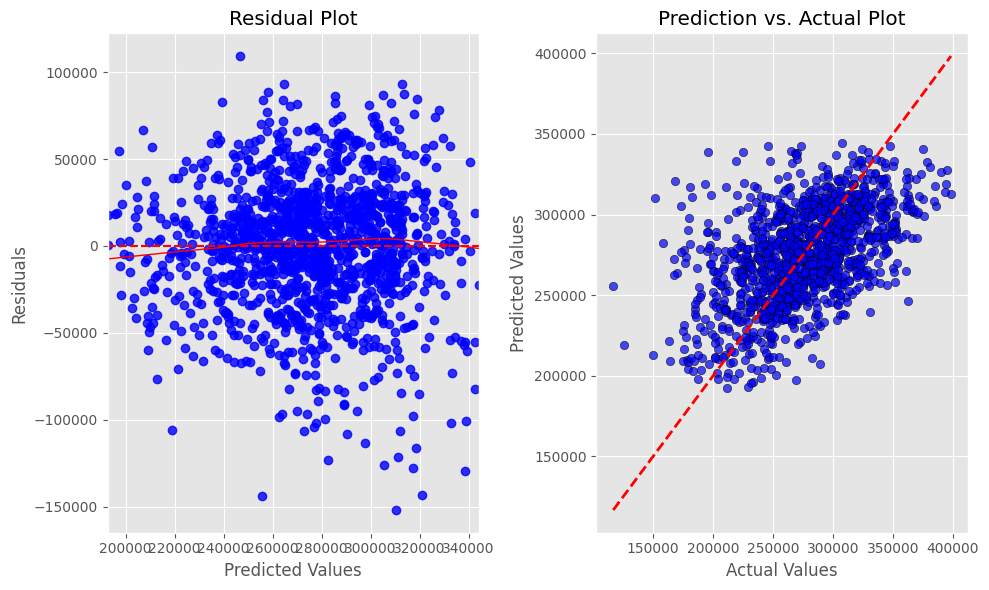

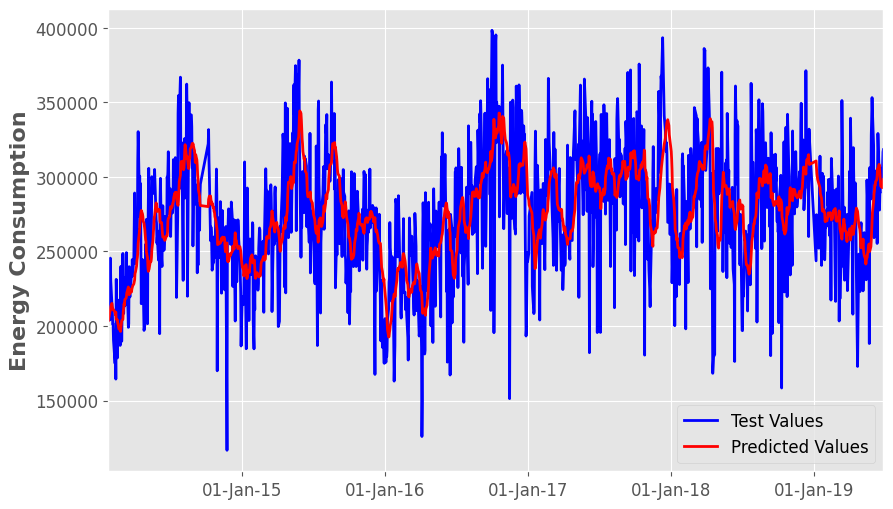

In [192]:
plot_res(fgs,df_Y_filtered[14:],y_pred_bayes)
print('\n')
plot_ts(fgs, df_Y_filtered[14:], y_pred_bayes, 'Energy Consumption')